In [46]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np

In [47]:
from services.SQLiteService import SQLiteService

database = SQLiteService()
database.connect()
data = database.select_data()

In [48]:
import pandas as pd
from datetime import datetime

# Conversion en DataFrame
df = pd.DataFrame(data)

# Conversion de la colonne datetime en type datetime
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M')

# Définition de l'index temporel
df = df.set_index('datetime').sort_index()

# Vérification des types
print(df.dtypes)

temperature    float64
dtype: object


In [49]:
df.head()

,temperature
datetime,
2025-01-01 00:00:00,0.8
2025-01-01 01:00:00,2.1
2025-01-01 02:00:00,2.6
2025-01-01 03:00:00,3.1
2025-01-01 04:00:00,3.6


In [50]:
from statsmodels.tsa.stattools import adfuller

# Effectuer le test ADF
result = adfuller(df['temperature'])

# Afficher les résultats
print("Statistique de test ADF:", result[0])
print("p-value:", result[1])
print("Nombre de retards utilisés:", result[2])
print("Nombre d'observations:", result[3])
print("Valeurs critiques:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

Statistique de test ADF: -2.506272107825606
p-value: 0.1139557021576712
Nombre de retards utilisés: 21
Nombre d'observations: 770
Valeurs critiques:
   1%: -3.4388710830827125
   5%: -2.8653008652386576
   10%: -2.568772659807725


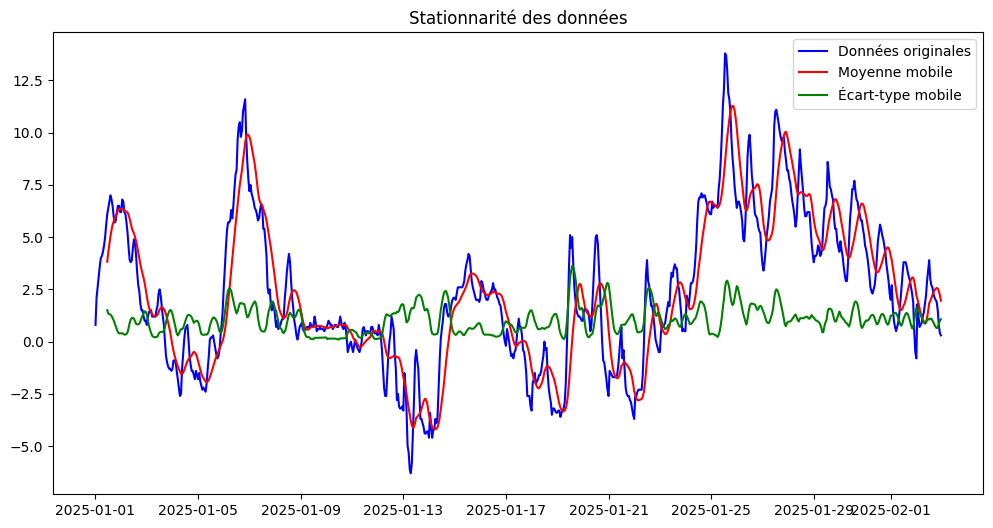

Statistique ADF : -2.506272107825606
p-value : 0.1139557021576712
La série n'est pas stationnaire (p-value >= 0.05).


In [51]:
from utils.adfuller import execute as adf_execute

# Calculer la moyenne mobile et l'écart-type mobile
rolling_mean = df['temperature'].rolling(window=12).mean()
rolling_std = df['temperature'].rolling(window=12).std()

# Tracer les données
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['temperature'], label='Données originales', color='blue')
plt.plot(rolling_mean, label='Moyenne mobile', color='red')
plt.plot(rolling_std, label='Écart-type mobile', color='green')
plt.legend(loc='best')
plt.title('Stationnarité des données')
plt.show()


adf_execute(df['temperature'])

In [52]:
from sklearn.model_selection import train_test_split

# Fractionner les données en ensembles d'entraînement et de test
train, test = train_test_split(df['temperature'], test_size=0.2, shuffle=False)

# Vérifier les dimensions des ensembles
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


Train shape: (633,)
Test shape: (159,)


c:\Users\NeoSk\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\NeoSk\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\NeoSk\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\NeoSk\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\NeoSk\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\tsa\base\t

Meilleur AIC: 642.6803607218303
Meilleur paramètre: (1, 1, 1)
Meilleur paramètre saisonnier: (0, 1, 1, 24)


c:\Users\NeoSk\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\NeoSk\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                  633
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood                -317.340
Date:                            Fri, 11 Apr 2025   AIC                            642.680
Time:                                    16:59:32   BIC                            660.146
Sample:                                01-01-2025   HQIC                           649.489
                                     - 01-27-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5608      0.066      8.486      0.000       0.431       0.690
ma.L1         -0.1762      0.078   

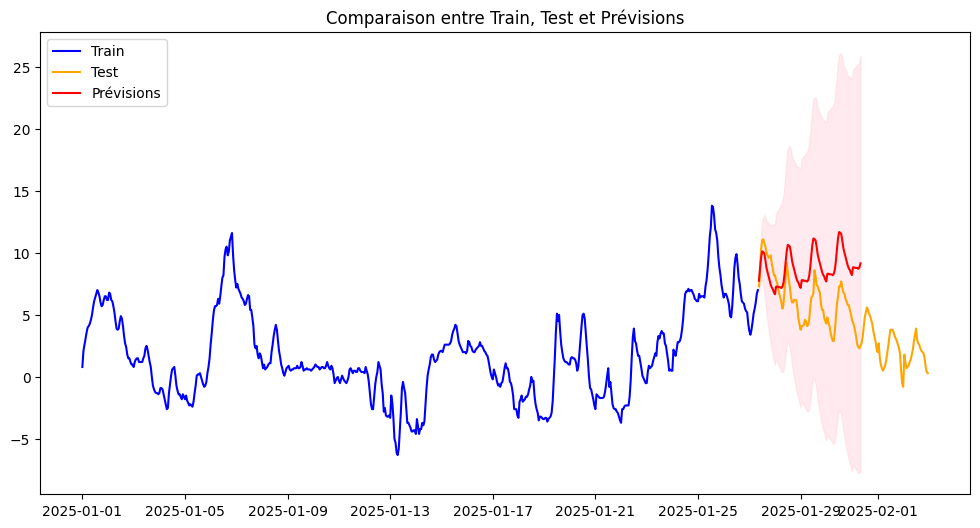

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
# Ensure the required module is installed

# Ordre non-saisonnier (p,d,q) et saisonnier (P,D,Q,s)
# s=24 pour des données horaires avec cycle quotidien
# Définir les plages de paramètres pour le grid search
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = [24]  # Période saisonnière pour des données horaires

# Créer toutes les combinaisons possibles de paramètres
parametres = list(product(p, d, q))
parametres_saisonniers = list(product(P, D, Q, s))

# Initialiser les meilleures valeurs
meilleur_aic = float("inf")
meilleur_parametre = None
meilleur_parametre_saisonnier = None

# Grid search
for param in parametres:
    for param_saisonnier in parametres_saisonniers:
        try:
            model = SARIMAX(train,
                            order=param,
                            seasonal_order=param_saisonnier,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < meilleur_aic:
                meilleur_aic = results.aic
                meilleur_parametre = param
                meilleur_parametre_saisonnier = param_saisonnier
        except Exception as e:
            continue

print(f"Meilleur AIC: {meilleur_aic}")
print(f"Meilleur paramètre: {meilleur_parametre}")
print(f"Meilleur paramètre saisonnier: {meilleur_parametre_saisonnier}")

# Utiliser les meilleurs paramètres pour ajuster le modèle final
model = SARIMAX(train,
                order=meilleur_parametre,
                seasonal_order=meilleur_parametre_saisonnier,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())

# Prédictions
pred = results.get_forecast(steps=96)  # Prédire 48h
pred_ci = pred.conf_int()

# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(pred.predicted_mean.index, pred.predicted_mean, 
         color='red', label='Prévisions')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.legend()
plt.title('Comparaison entre Train, Test et Prévisions')
plt.show()
